In [32]:
# run initial imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from fbprophet import Prophet

from ipywidgets import widgets

from datetime import datetime

In [33]:
NOW = datetime.now()
input_dir = './data/'
covid_19_national_observations = pd.read_csv(input_dir + 'global/covid_19_national_observations.csv')

In [34]:
countries = covid_19_national_observations['Country/Region'].unique()

In [39]:
def analyze_country(country):
    c = country.lower().replace(' ', '_')
    #setup initial data frames
    input_dir = './data/countries/' + c + '/'
    cases = pd.read_csv(input_dir + 'covid_19_'+ c +'_cases.csv')
    totals = pd.read_csv(input_dir + './covid_19_' + c + '_totals.csv')
    
    #correct date parsing on some of the JH data
    cases['Date'] = pd.to_datetime(cases['Date'])
    totals['Date'] = pd.to_datetime(totals['Date'])
    
    cases = cases.sort_values('Date')
    totals = totals.sort_values('Date')
    
    cases = cases[cases['Confirmed'] > 0]
    
    likelyTotal = int(totals['Likely Cases C86'].max())
    confirmedActive = int(totals['Active Cases'].iloc[-1])
    recovered = int(totals['Recovered'].iloc[-1])
    dead = int(totals['Death'].iloc[-1])
    #print(likelyTotal, confirmedActive)
    
    confirmed_chart = px.bar(cases, 
        x="Date", y="Confirmed", color="Province/State", title="Confirmed "+country+" Cases")
    confirmed_chart.show()

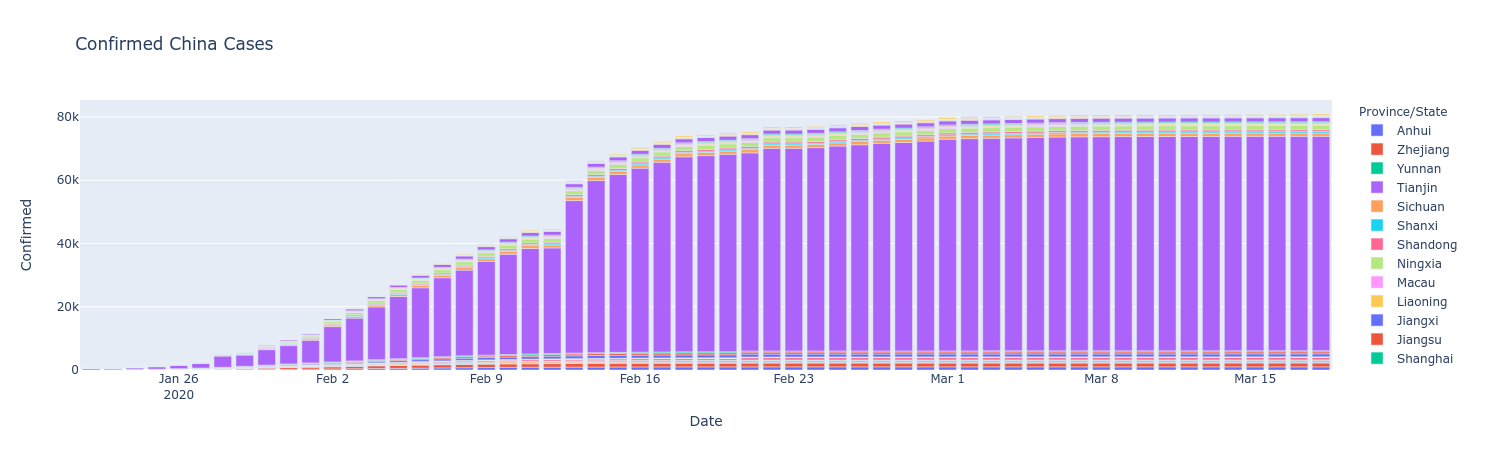

In [41]:
analyze_country('China')

CN Test Rate: 0.0028193832599118945
US Test Rate: 0.00017714782737432062


In [7]:
us_totals['Likely Cases C86'].max()

8738.099999999999

In [8]:
#display(covid_19_ts[covid_19_ts['Country/Region'] == 'US'])

In [9]:
us_totals['Total Deaths'].max() / us_totals['Total Confirmed'].max() 

0.015161248875754851

In [10]:
#display(us_cases)

In [11]:
#display(covid_19_by_date)

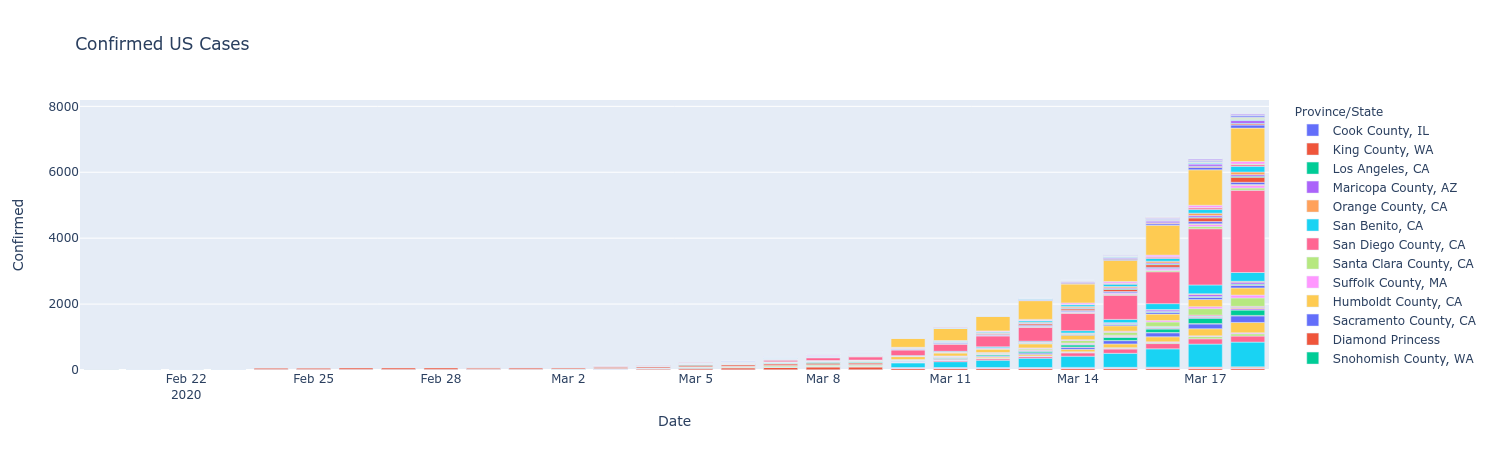

In [12]:
us_chart = px.bar(us_cases[us_cases['Date'] >= '2020-02-20'], 
    x="Date", y="Confirmed", color="Province/State", title="Confirmed US Cases")
us_chart.show()

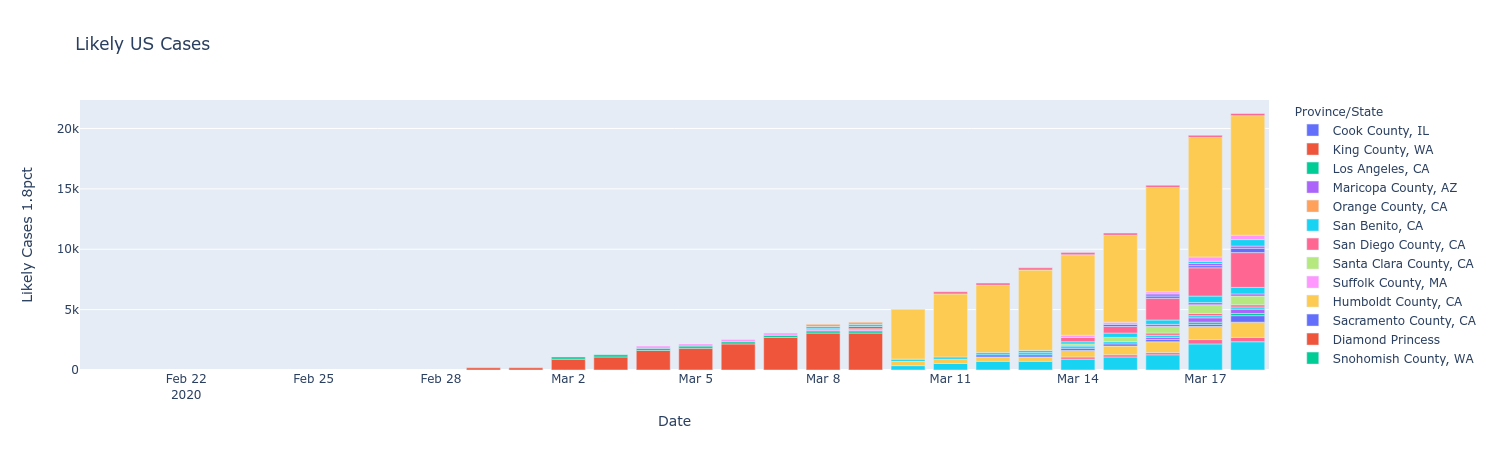

In [13]:
us_chart = px.bar(us_cases[us_cases['Date'] >= '2020-02-20'], 
    x="Date", y="Likely Cases 1.8pct", color="Province/State", title="Likely US Cases")
us_chart.show()

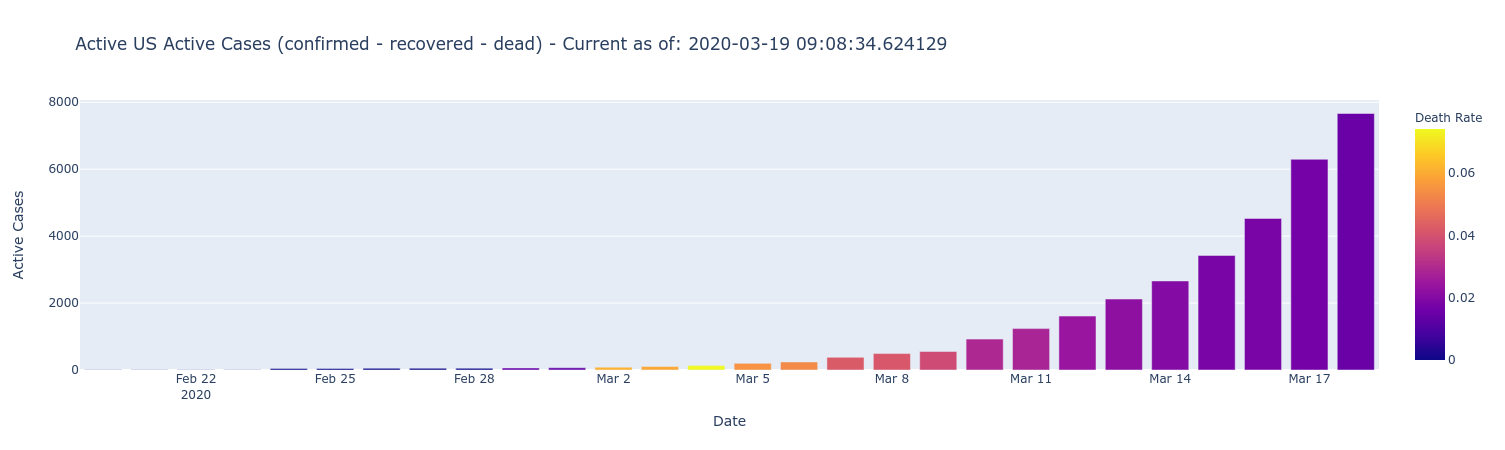

In [14]:
us_chart = px.bar(us_totals[us_totals['Date'] >= '2020-02-20'], 
    x="Date", y="Active Cases", color="Death Rate", 
    title="Active US Active Cases (confirmed - recovered - dead) - Current as of: "+str(NOW), 
    )
us_chart.show()

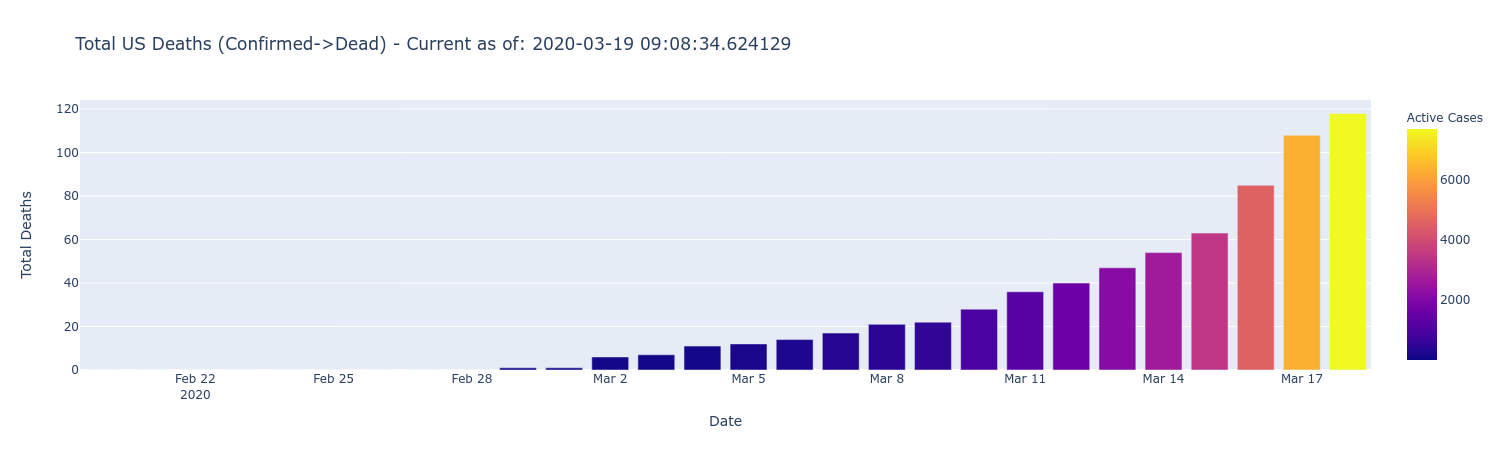

In [15]:
us_chart = px.bar(us_totals[us_totals['Date'] >= '2020-02-20'], 
    x="Date", y="Total Deaths", color="Active Cases", 
    title="Total US Deaths (Confirmed->Dead) - Current as of: "+str(NOW), 
    )
us_chart.show()

In [17]:
us_totals['New Active Cases'] = us_totals['Active Cases'] - us_totals['Active Cases'].shift()
us_totals['New Cases'] = us_totals['Confirmed'] - us_totals['Confirmed'].shift()
us_totals['New Case PCT Change'] = us_totals['Confirmed'].pct_change()

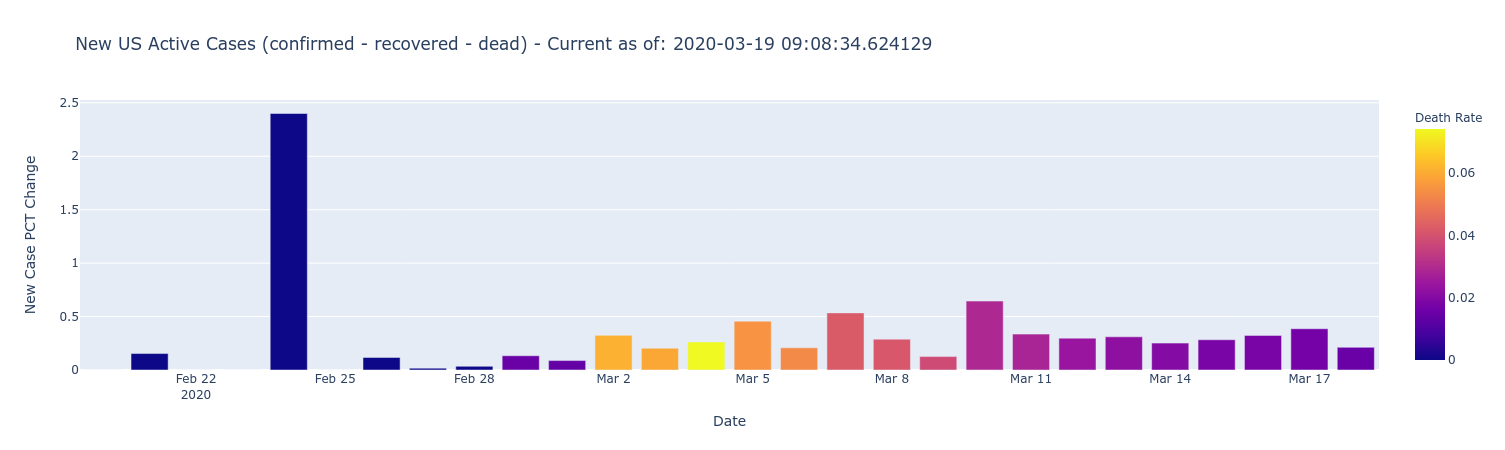

In [18]:
us_chart = px.bar(us_totals[us_totals['Date'] >= '2020-02-20'], 
    x="Date", y="New Case PCT Change", color="Death Rate", 
    title="New US Active Cases (confirmed - recovered - dead) - Current as of: "+str(NOW), 
    )
us_chart.show()

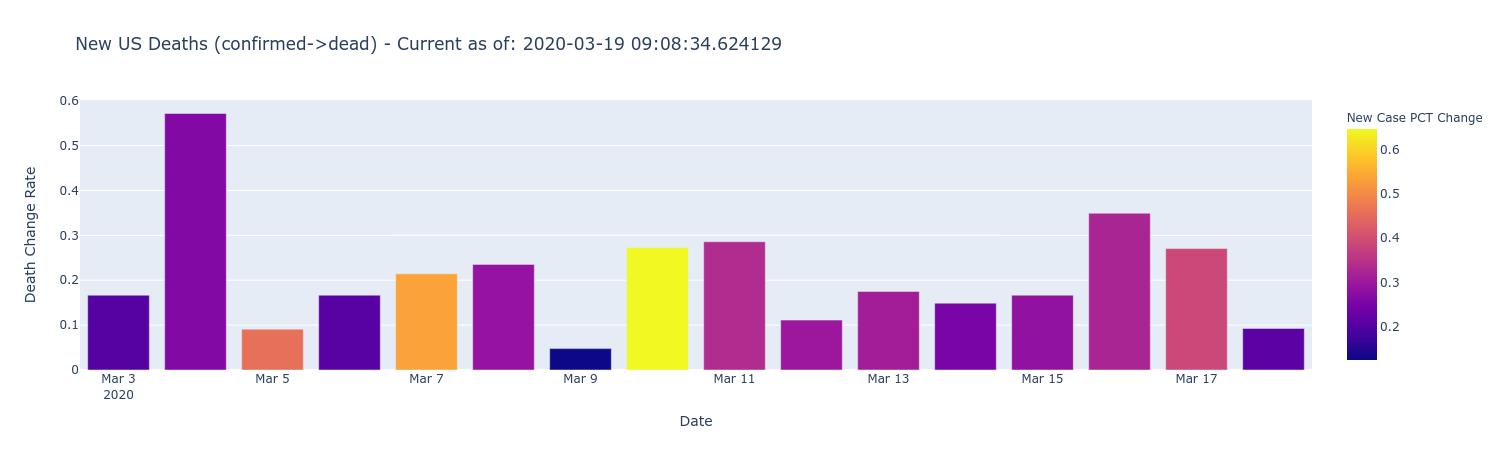

In [19]:
us_chart = px.bar(us_totals[us_totals['Date'] >= '2020-03-03'], 
    x="Date", y="Death Change Rate", color="New Case PCT Change", 
    title="New US Deaths (confirmed->dead) - Current as of: "+str(NOW), 
    )
us_chart.show()

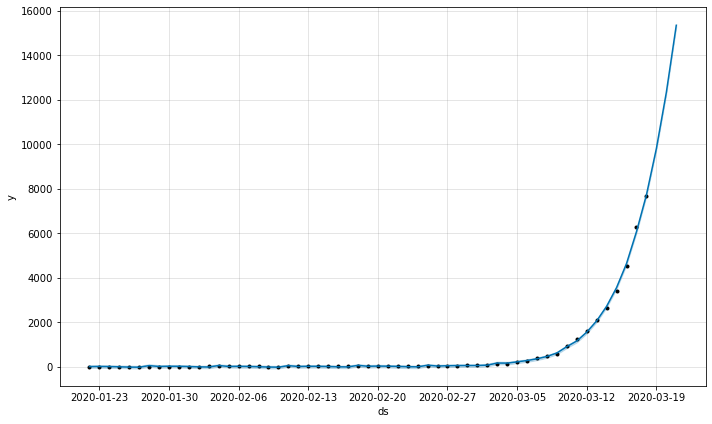

In [27]:
fb_df = us_totals[['Date', 'Active Cases']].copy()
fb_df = fb_df.sort_values('Date').reset_index(drop=True)
fb_df.columns = ['ds','y']
#print(fb_df)

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, growth='linear')
m.fit(fb_df)

future = m.make_future_dataframe(periods=3)

forecast = m.predict(future)

fig1 = m.plot(forecast)

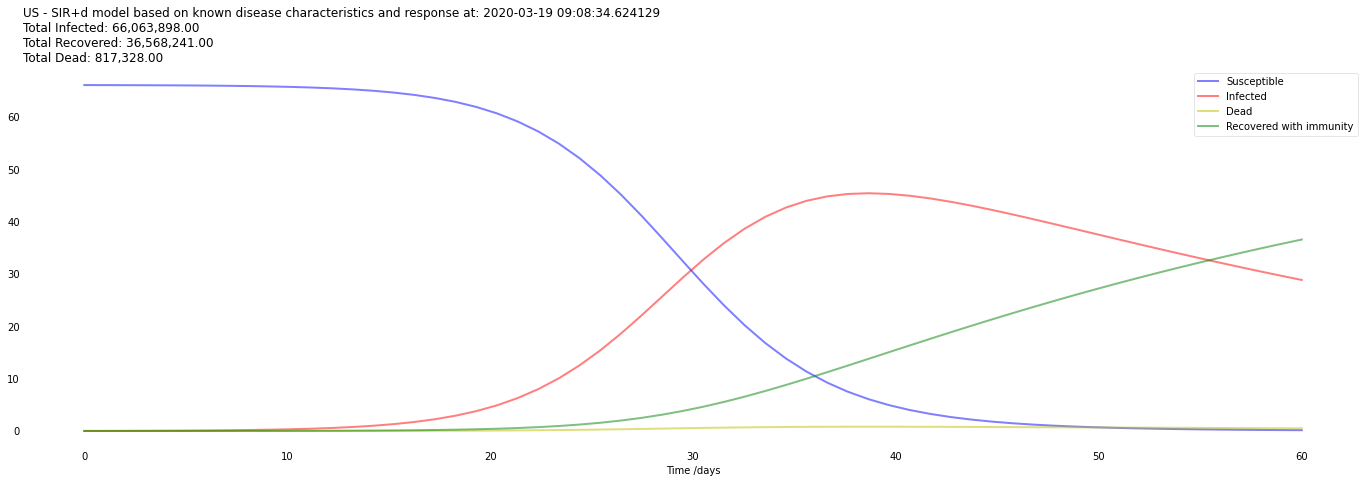

In [28]:
# see here for some good parameter tuning
N = US_pop * 0.2
T=60
I0, R0 = us_totals['Likely Cases 1.8pct'].max(), us_totals['Recovered'].max()*120
S0 = N - I0 - R0
beta, gamma = 0.3, 1/36
t = np.linspace(0, T, T)
y0 = S0, I0, R0

#SIR Deriv
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

D = (I/1000000)*0.018
R = (R/1000000) - D

fig = plt.figure(figsize=(24,7), facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, D, 'y', alpha=0.5, lw=2, label='Dead')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_title('US - SIR+d model based on known disease characteristics and response at: '+str(NOW) + 
            '\nTotal Infected: '+'{:,.2f}'.format(int(np.max(S)))+
            '\nTotal Recovered: '+'{:,.2f}'.format(int(np.max(R)*1000000))+
            '\nTotal Dead: '+'{:,.2f}'.format(int(np.max(D)*1000000)),
            loc='left'
            )
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

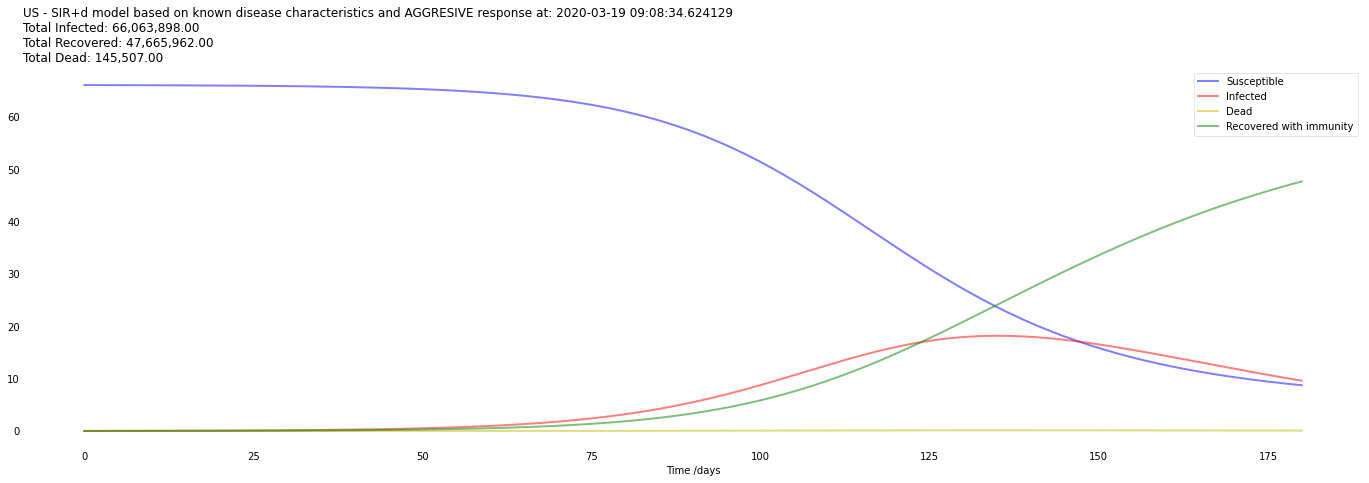

In [29]:
N = US_pop * 0.2
T=180
I0, R0 = us_totals['Likely Cases 1.8pct'].max(), us_totals['Recovered'].max()*120
S0 = N - I0 - R0
beta, gamma = 0.1, 1/28
t = np.linspace(0, T, T)
y0 = S0, I0, R0

#SIR Deriv
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

D = (I/1000000)*0.008
R = (R/1000000) - D

fig = plt.figure(figsize=(24,7), facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, D, 'y', alpha=0.5, lw=2, label='Dead')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_title('US - SIR+d model based on known disease characteristics and AGGRESIVE response at: '+str(NOW) + 
            '\nTotal Infected: '+'{:,.2f}'.format(int(np.max(S)))+
            '\nTotal Recovered: '+'{:,.2f}'.format(int(np.max(R)*1000000))+
            '\nTotal Dead: '+'{:,.2f}'.format(int(np.max(D)*1000000)),
            loc='left'
            )
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()